# Entorno

In [1]:
import torch
import torchaudio
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
from pydub import AudioSegment
from scripts.plot import plot_audio_sample
from scripts.extract import load_heart_noised_paths
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor


# Relación de datos

In [2]:
heart_noised = load_heart_noised_paths(
    clean_dir="data/heart_sound_test_small",
    noised_dir="data/heart_noised_test_small",
)

heart_noised[:3]

[('data/heart_sound_test_small/val/healthy/e00052.wav',
  'data/heart_noised_test_small/-val-healthy-e00052_seg_154noise_-17dB_louder.wav'),
 ('data/heart_sound_test_small/val/healthy/e00052.wav',
  'data/heart_noised_test_small/-val-healthy-e00052_seg_1noise_-14dB_louder.wav'),
 ('data/heart_sound_test_small/val/healthy/e00052.wav',
  'data/heart_noised_test_small/-val-healthy-e00052_seg_538noise_-15dB_louder.wav')]

# Cómo suena?

In [3]:
test = heart_noised[22]

audio_clean = AudioSegment.from_file(test[0])
audio_noisy = AudioSegment.from_file(test[1])

In [4]:
audio_clean

In [5]:
audio_noisy

# Cómo se ve?

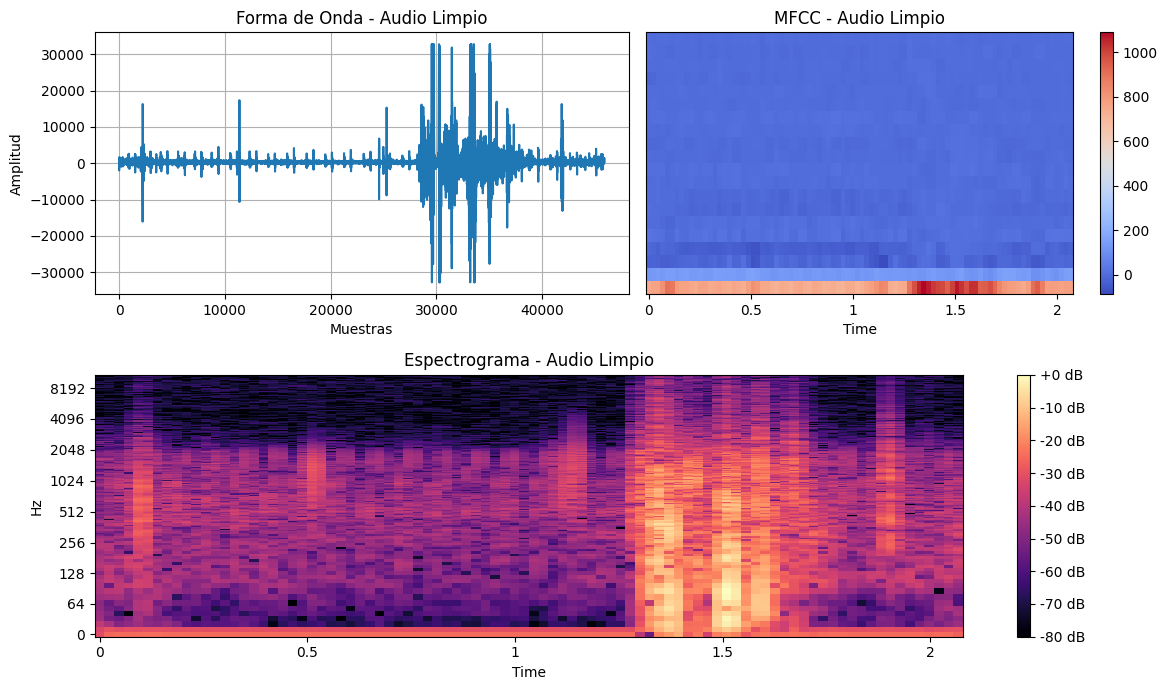

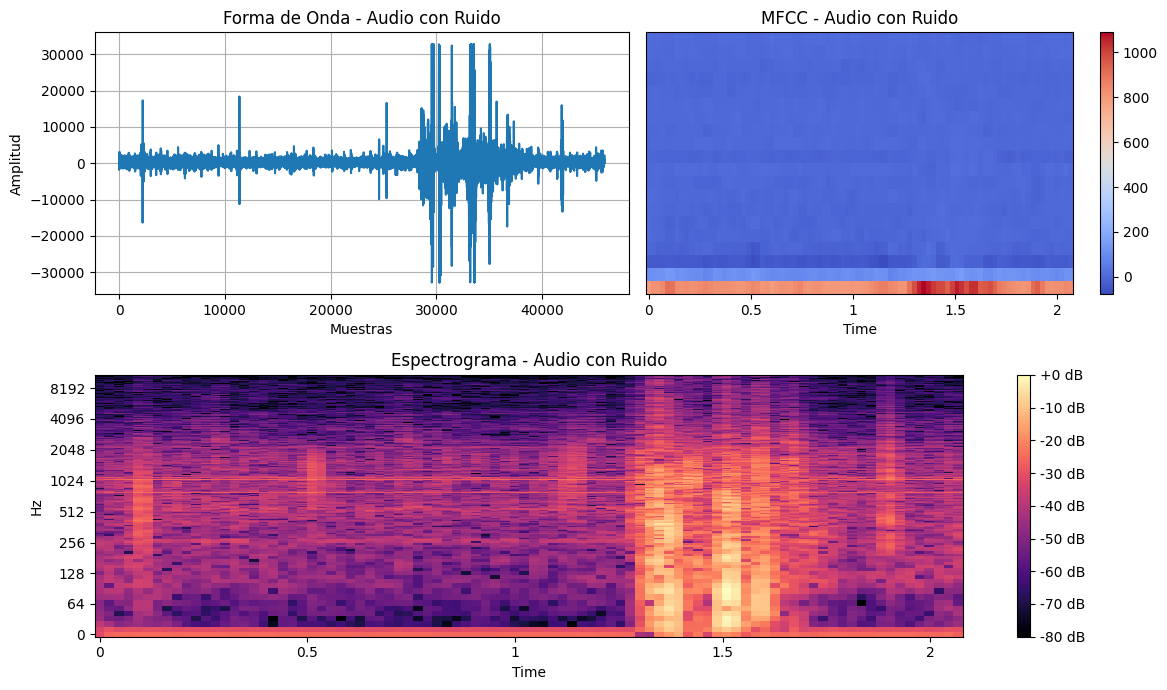

In [6]:
clean_array = np.array(audio_clean.get_array_of_samples())
noisy_array = np.array(audio_noisy.get_array_of_samples())

plot_audio_sample(clean_array, 'Audio Limpio')
plot_audio_sample(noisy_array, 'Audio con Ruido')

In [7]:
clean_array.shape, noisy_array.shape

((45888,), (45888,))

# Arquitectura

In [8]:
class Autoencoder(pl.LightningModule):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded
    
    def training_step(self, batch, batch_idx):
        clean, noisy = batch
        # Forward pass
        decoded = self(noisy)
        # Calculamos la pérdida (error de reconstrucción)
        train_loss = nn.MSELoss()(decoded, clean)
        # Registramos la pérdida para su monitoreo
        self.log('train_loss', train_loss, on_epoch=True)

        return train_loss
    
    def validation_step(self, batch, batch_idx):
        clean, noisy = batch
        decoded = self(noisy)
        val_loss = nn.MSELoss()(decoded, clean)
        self.log('val_loss', val_loss, on_epoch=True)

        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        # optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)

        scheduler = {
            'scheduler': CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False),
            'interval': 'step',     # Frecuencia de ajuste del LR scheduler (en cada paso)
        }

        # scheduler = {
        #     'scheduler': ReduceLROnPlateau(optimizer, patience=3),
        #     'monitor': 'val_loss',  # Métrica para monitorear
        #     'interval': 'epoch',    # Frecuencia de ajuste del LR scheduler
        #     'frequency': 1          # Igual a interval, ya que estamos usando 'epoch'
        # }

        return [optimizer], [scheduler]

# CustomDataset class

In [9]:
class CoraCleanerDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data_tuples = data_tuples
        self.transform = transform
        # Calcular la duración mínima de todos los audios
        self.min_duration = self.calculate_min_duration()

    def __len__(self):
        return len(self.data_tuples)
    
    def calculate_min_duration(self):
        self.durations = []
        for _, audio_path in self.data_tuples:
            audio, _ = torchaudio.load(audio_path)
            self.durations.append(audio.shape[-1])

        return min(self.durations)
    
    def adjust_audio_duration(self, audio, target_duration):
        if audio.shape[-1] > target_duration:
            audio = audio[..., :target_duration]
        return audio
    
    def normalize_audio(self, audio):
        normalized = (audio - audio.mean()) / audio.std()
        return normalized.reshape(1, 1, -1)

    def __getitem__(self, idx):
        clean_audio_path = self.data_tuples[idx][0]
        clean_audio, sample_rate = torchaudio.load(clean_audio_path)
        clean_audio = self.adjust_audio_duration(clean_audio, self.min_duration)
        clean_audio = self.normalize_audio(clean_audio)

        noisy_audio_path = self.data_tuples[idx][1]
        noisy_audio, sample_rate = torchaudio.load(noisy_audio_path)
        noisy_audio = self.adjust_audio_duration(noisy_audio, self.min_duration)
        noisy_audio = self.normalize_audio(noisy_audio)

        if self.transform:
            clean_audio = self.transform(clean_audio, sample_rate)
            noisy_audio = self.transform(noisy_audio, sample_rate)

        return clean_audio, noisy_audio

In [10]:
from scripts.transform import spec_n_mfcc

# cleaner_dataset = CoraCleanerDataset(heart_noised, spec_n_mfcc)
cleaner_dataset = CoraCleanerDataset(heart_noised)

print(len(cleaner_dataset))
cleaner_dataset[5][0].shape, cleaner_dataset[5][1].shape

80


(torch.Size([1, 1, 18902]), torch.Size([1, 1, 18902]))

In [12]:
# import matplotlib.pyplot as plt

# plt.plot(cleaner_dataset[0][0].reshape(-1)[:cleaner_dataset.min_duration])
# plt.plot(cleaner_dataset[0][-1].reshape(-1)[:cleaner_dataset.min_duration])

# Conjuntos de datos

In [13]:
batch_size = 16
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(cleaner_dataset))
val_size = int(val_ratio * len(cleaner_dataset))
test_size = len(cleaner_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(cleaner_dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Callbacks

In [14]:

checkpoint = ModelCheckpoint(
    monitor='val_loss',  # Métrica a monitorear para determinar el mejor modelo
    dirpath='checkpoints/',  # Directorio para guardar los modelos
    filename='autoencoder-{epoch:02d}-{val_loss:.4f}',  # Formato del nombre del archivo
    save_top_k=1,  # Guardar solo el mejor modelo
    mode='min'  # 'min' o 'max' según si la métrica debe ser menor o mayor para ser "mejor"
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear para detener el entrenamiento
    patience=5,  # Número de épocas sin mejora antes de detener
    mode='min'  # 'min' o 'max' según si la métrica debe ser menor o mayor para detener
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# callbacks = [checkpoint, early_stopping, lr_monitor]
callbacks = [checkpoint, lr_monitor]

# Entrenamiento

In [15]:
from pytorch_lightning import Trainer

input_size = cleaner_dataset[0][0].shape[-1]
model = Autoencoder(input_size=input_size, latent_dim=64)

trainer = Trainer(max_epochs=3, callbacks=callbacks)
trainer.fit(model, train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`

Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 56.50it/s, v_num=12]

/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_loss_epoch', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)
`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 54.76it/s, v_num=12]
